This notebook enables to test the code written for the resnet model

# Imoorting Librairies

In [1]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2

import torch
import torch.nn as nn
import torch.optim as optim



# Import MNIST data
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


from tqdm.notebook import tqdm




try : 
    Actual_Path = os.getcwd()
    os.chdir('./Modules')
    os.chdir('./Models')
    from resnet import *
    os.chdir('..')
    from preprocessing import *
    from train import *

    print('Modules Imported')
except:
    print('Error in importing Modules')
finally:
    os.chdir(Actual_Path)

Modules Imported


In [2]:
# Load the MNIST data

transform_mnist = transforms.Compose([
    transforms.ToTensor(),
    # Resize to 32x32
    transforms.Resize((32, 32)),
    transforms.Grayscale(num_output_channels=1),
    # Inverser les couleurs
    transforms.Lambda(lambda x: 1-x),
])

train_data , test_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform_mnist), datasets.MNIST(root='./data', train=False, download=True, transform=transform_mnist)

train_dataloader, test_dataloader = DataLoader(train_data, batch_size=32, shuffle=True), DataLoader(test_data, batch_size=32, shuffle=False)

In [3]:
# Data Augmentation

transform = v2.Compose([
    v2.RandomAffine(degrees=10, translate=(0.005, 0.005)),
    v2.GaussianBlur(kernel_size=3),
    v2.RandomRotation(degrees=40),
    v2.ToTensor(),
])


/home/ayoubchoukri/anaconda3/envs/Personal/lib/python3.12/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [5]:
def create_dataset_augmented(dataset, transform,nb_augmented=3):
    augmented_data = []

    ProgressBar = tqdm(total=len(dataset)*nb_augmented)
    for i in range(len(dataset)):
        for j in range(nb_augmented):
            augmented_data.append((transform(dataset[i][0]), dataset[i][1]))
            ProgressBar.update(1)
    ProgressBar.close()

    return augmented_data





train_data_augmented = create_dataset_augmented(train_data, transform)


# Concatenate the original dataset with the augmented dataset
train_data_augmented = train_data + train_data_augmented

train_dataloader_augmented = DataLoader(train_data_augmented, batch_size=32, shuffle=True)



  0%|          | 0/180000 [00:00<?, ?it/s]

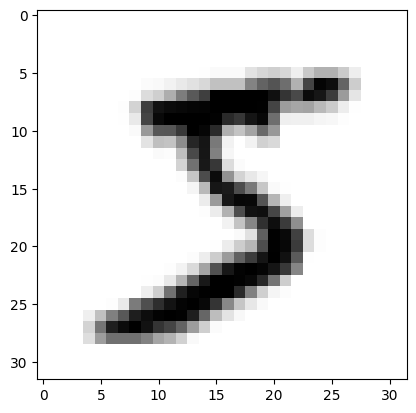

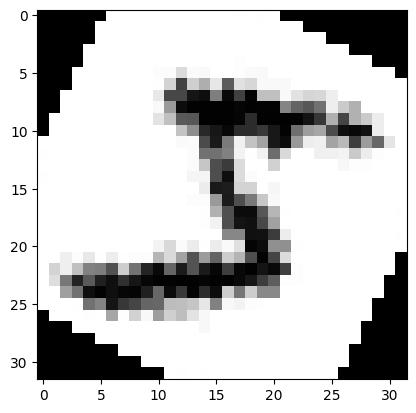

In [6]:
img_random = train_data[0][0]   

plt.imshow(img_random.squeeze(), cmap='gray')

plt.show()
img_random = transform(img_random)

plt.imshow(img_random.squeeze(), cmap='gray')

plt.show()

1.0 0.0057138205


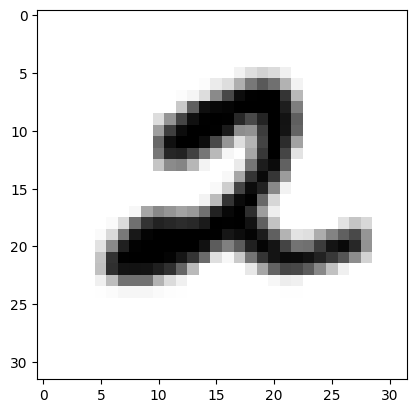

In [7]:
img = train_data[np.random.randint(0, len(train_data))][0].squeeze().numpy()
print(img.max(), img.min())
plt.imshow(img, cmap='gray')




# Resnet 18

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu' 
device

'cuda'

In [10]:
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=25, device='cuda'):
    """
    Train the model on the dataset.

    Parameters
    ----------
    model : torch.nn.Module
        The model to train.
    train_loader : torch.utils.data.DataLoader
        The DataLoader for the training set.
    test_loader : torch.utils.data.DataLoader
        The DataLoader for the test set.
    criterion : torch.nn.modules.loss._Loss
        The loss function to use.
    optimizer : torch.optim.Optimizer
        The optimizer to use.
    num_epochs : int, optional
        The number of epochs to train the model (default is 25).
    device : str, optional
        The device to train on ('cuda' or 'cpu', default is 'cuda').

    Returns
    -------
    model : torch.nn.Module
        The trained model.
    train_losses : list
        The training losses per epoch.
    test_losses : list
        The test losses per epoch.
    """

    model.to(device)
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []
    Running_Losses = []
    Running_Accuracies = []

    EpochBar = tqdm(range(num_epochs), desc="Epochs")
    for epoch in EpochBar:

        model.train()

        ProgressBar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
        
        Train_Loss = 0
        Train_Accuracy = 0


        for inputs, labels in ProgressBar : 
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            inputs = inputs.float()
            outputs = model(inputs)
            labels = labels.long()

            loss = criterion(outputs, labels)
            loss.backward()


            optimizer.step()

            running_loss = loss.item() * inputs.size(0)
            Running_Losses.append(running_loss)
            Train_Loss += running_loss * inputs.size(0)


            running_corrects = torch.sum(torch.argmax(outputs, 1) == labels).item()
            Running_Accuracies.append(running_corrects/len(inputs))

            Train_Accuracy += running_corrects


            
            ProgressBar.set_description(f"Epoch {epoch+1}/{num_epochs}, Running Train Loss: {loss.item():.4f}, Running Train Accuracy: {100 * running_corrects / len(inputs):.2f}%")

        


        Train_Loss = running_loss / len(train_loader.dataset)
        train_losses.append(Train_Loss)
        Train_Accuracy = 100 * Train_Accuracy / len(train_loader.dataset)
        train_accuracies.append(Train_Accuracy)

        

        model.eval()
        test_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            
            ProgressBar_Inner = tqdm(test_loader, desc="Testing", leave=False)

            for inputs, labels in ProgressBar_Inner:
                inputs, labels = inputs.to(device), labels.to(device)
                inputs = inputs.float()
                outputs = model(inputs)
                labels = labels.long()

                loss = criterion(outputs, labels)
                test_loss += loss.item() * inputs.size(0)

                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            ProgressBar_Inner.set_description(f"Epoch {epoch+1}/{num_epochs}, Test Loss: {loss.item():.4f}, Test Accuracy: {100 * correct / total:.2f}%")

        epoch_test_loss = test_loss / len(test_loader.dataset)
        test_losses.append(epoch_test_loss)
        Test_Accuracy = 100 * correct / total
        test_accuracies.append(Test_Accuracy)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {Train_Loss:.4f}, Train Accuracy: {Train_Accuracy:.2f}%, Test Loss: {epoch_test_loss:.4f}, Test Accuracy: {Test_Accuracy:.2f}%")

    return model, train_losses, test_losses, train_accuracies, test_accuracies


In [11]:
model = resnet18(in_channels=1, num_classes=10)


criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

model, train_losses, test_losses, train_accuracies, test_accuracies = train_model(model, train_dataloader_augmented, test_dataloader, criterion, optimizer, num_epochs=10, device=device)

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10:   0%|          | 0/7500 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch [1/10], Train Loss: 0.0000, Train Accuracy: 96.17%, Test Loss: 0.0379, Test Accuracy: 98.89%


Epoch 2/10:   0%|          | 0/7500 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [54]:
# Save the model

torch.save(model.state_dict(), 'resnet18_mnist.pth')



In [30]:
# Load the model

model = resnet18(in_channels=1, num_classes=10)

model.load_state_dict(torch.load('resnet18_mnist.pth',map_location=torch.device("cpu")))



<All keys matched successfully>

Predicted: 7


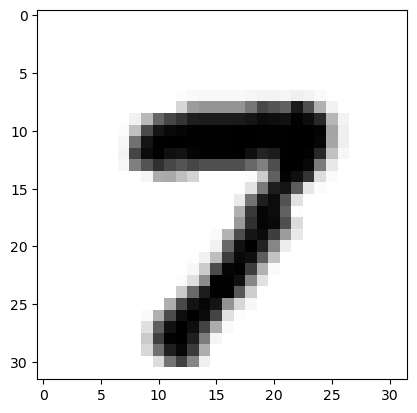

In [46]:
img_test = test_data[np.random.randint(0, len(test_data))][0].unsqueeze(0).to(device)   



model.eval()

with torch.no_grad():

    output = model(img_test.float())

    _, predicted = torch.max(output, 1)

    print(f"Predicted: {predicted.item()}")

    plt.imshow(img_test.squeeze().cpu().numpy(), cmap='gray')
    plt.show()



Predicted: 1


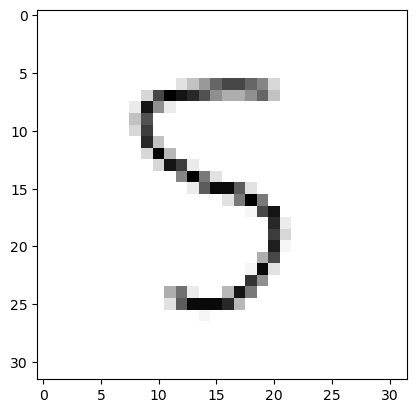

In [111]:
# Dessiner une image à la main

from PIL import Image

img = Image.open('drawing.png').convert('L')

# transform to 32x32
img = img.resize((32, 32))


img = v2.ToTensor()(img).unsqueeze(0).to(device)

model.eval()

with torch.no_grad():
    
    output = model(img.float())

    _, predicted = torch.max(output, 1)

    print(f"Predicted: {predicted.item()}")

    plt.imshow(img.squeeze().cpu().numpy(), cmap='gray')
    plt.show()


